# Modeling Gaussian Process Regression 

Gaussian Process can be used as a generic supervised learning method for solving regression problem and it has the benefits of 
- working well on small datasets
- providing uncertainty estimation on the predictions
- representing non-linear relationships

In this notebook we'll show how to train a Gaussian process regression using the main functions of the `modeling` package on a small example data set and display the uncertainty estimates for the predictions.

## Setup
First, we set up and create some data.

In [1]:
import typing as tp
import logging
import sys

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
# Resolve path when used in a usecase project
from pathlib import Path

sys.path.insert(0, str(Path("../../").resolve()))

We generate a toy data with non linear relationship using the ["Friedman #1" regression problem](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html#sklearn.datasets.make_friedman1). 

In [3]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_friedman1

N_SAMPLES = 50
N_FEATURES = 5
NOISE = 0.5
RANDOM_STATE = 18

model_features = [f"Feature_{i + 1}" for i in range(N_FEATURES)]
model_target = "Target"

X, y = make_friedman1(
    n_samples=N_SAMPLES, 
    n_features=N_FEATURES,
    noise=NOISE,
    random_state=RANDOM_STATE,
)
features_data = pd.DataFrame(X, columns=model_features)
target_vector = pd.DataFrame(y, columns=[model_target])

master_data = pd.concat([features_data, target_vector], axis=1)
master_data['Target'] = (master_data['Target'] - master_data['Target'].mean()) / master_data['Target'].std()
master_data.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Target
0,0.650374,0.505453,0.878601,0.181840,0.852233,0.465399
1,0.750136,0.666102,0.987895,0.256968,0.028306,0.540001
2,0.635719,0.847312,0.736175,0.020807,0.111603,-0.457612
3,0.297724,0.686970,0.861626,0.198634,0.657189,-0.098747
4,0.699656,0.352392,0.789961,0.814048,0.197421,0.496910


## Create Gaussian Process regressor

Gaussian process models are mainly defined by it's covariance function through a [`kernel`](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

Users can define different kernels that suit to the purpose of the process. For user defined kernels, please follow the examples provided by the `sklearn` base class for all [`kernels`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Kernel.html#sklearn.gaussian_process.kernels.Kernel).

In the example below, we use one of the most commonly seen kernel, the `Matern` kernel to define the Gaussian process as a illustration.

In [4]:
from modeling import SklearnModelFactory
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

class GaussianProcessFactory(SklearnModelFactory):
    
    @staticmethod
    def create_model_instance(
            init_config: tp.Dict[str, tp.Any],
    ) -> GaussianProcessRegressor:
        kernels_parameters = init_config["kernel_parameters"]
        gp_parameters = init_config["gp_parameters"]
        UserDefinedKernel = (
            Matern(**kernels_parameters['matern']) 
        )
        return GaussianProcessRegressor(
            kernel = UserDefinedKernel, 
            **gp_parameters,
        )
    

Next we intialize the `GaussianProcessFactory` by defining the dictionary of the parameters. There are two sets of parameters: 
- `kernel_parameters`: the hyper-parameters to define the kernel
- `gp_parameters`: the parameters for the gaussian process

In this example, we have chosen the `Matern` kernel, which is a generalization of the [`RBF`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) kernel. For the `Matern` kernel, we need to define three hyper-parameters:
- `length_scale`: the length scale of the kernel (in general, yo wont' be able to extrapolate more than the `length_scale` units away from your data).
- `nu`: controls the smoothness of the resulting function.
- `length_scale_bounds`: can be fixed; when given an interval, the `length_scale` can be tuned within the interval range.


In [5]:
gp_model_init_config = {
    "kernel_parameters":{
        "matern":{
            "length_scale": 1,
            "length_scale_bounds": (1e-05, 100000.0),
            "nu": 1.5,
        },
    },
    "gp_parameters":{
        "alpha": 1e-10,
        "optimizer": "fmin_l_bfgs_b",
        "n_restarts_optimizer": 0,
        "normalize_y": False,
        "random_state": 42,
    },
}

gp_model_factory = GaussianProcessFactory(
    gp_model_init_config,
    model_features,
    model_target,
)

Create the GP model and show the summary of the model.

In [6]:
gp_model = gp_model_factory.create()
gp_model

SklearnModel(estimator=GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5), random_state=42), target=Target, features_in=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5'])

Next we demostrate that we can still use the `train_model`, `calculate_model_predictions` and `calculate_metrics` from the `modelling` package.
First, we train the model by using the first 30 samples of the data.

In [7]:
from modeling import train_model

train_data = master_data[:30]
gp_model = train_model(gp_model, train_data)

Then we use the trained model to predict the remaining 20 samples.

In [8]:
from modeling import calculate_model_predictions

test_data = master_data[30:]
predictions = calculate_model_predictions(
    test_data, gp_model,
)

predictions.head()

,model_prediction
30,1.211296
31,0.048753
32,1.010666
33,1.307787
34,0.254020


Now we calculate the metrics on the test data.

In [9]:
from modeling import calculate_metrics

test_metrics = calculate_metrics(
    test_data, model=gp_model,
)
test_metrics

,metric_value
metric_name,
mae,0.377260
rmse,0.449685
mse,0.202217
mape,0.692803
r_squared,0.816140
var_score,0.819135


Finally, we show the evolution of the uncertainty bands of the predictions as we increase the training sample for the Gaussian process regression. 
For illustration purpose, we select the first feature to plot against the target variable. 
Below we first define a plotting function that will be used later on for the illustration.

In [10]:
import matplotlib.pyplot as plt


# This function is adapted from the sklearn documentation
def plot_gpr_samples(
    gpr_model: GaussianProcessFactory,
    n_samples: int,
    x_plot: pd.DataFrame,
    x_feature: str,
    ax: plt.Axes,
    data_train: pd.DataFrame = None,
    random_state: int = 42,
):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : a GaussianProcessFactory instance
    n_samples : The number of samples to draw from the Gaussian process 
    distribution
    x_plot : The array of feature values to plot the samples against
    x_feature : The name of the feature to plot the samples against
    ax : The matplotlib axis where to plot the samples.
    data_train : The data used to train the Gaussian process model, if None,
    then the samples are drawn from the prior distribution.
    random_state : int, RandomState instance or None, default=42
    """

    x_plot = x_plot.sort_values(by=[x_feature])
    if data_train is not None:
        gpr_model = train_model(gpr_model, data_train)

    y_mean, y_std = gpr_model.estimator.predict(x_plot, return_std=True)
    y_samples = gpr_model.estimator.sample_y(x_plot, n_samples, random_state)

    x_vals = x_plot[x_feature]
    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x_vals,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x_vals, y_mean, color="black", label="Mean")
    ax.fill_between(
        x_vals,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(gpr_model.target)
    ax.set_ylim([-3, 3])

We start from plotting samples from the prior distribution of the GP without knowing any observations. Then use 5 observations and finally 20 observations to train the GP regression and compare the prediction and uncertainties.

X has feature names, but GaussianProcessRegressor was fitted without feature names
X has feature names, but GaussianProcessRegressor was fitted without feature names


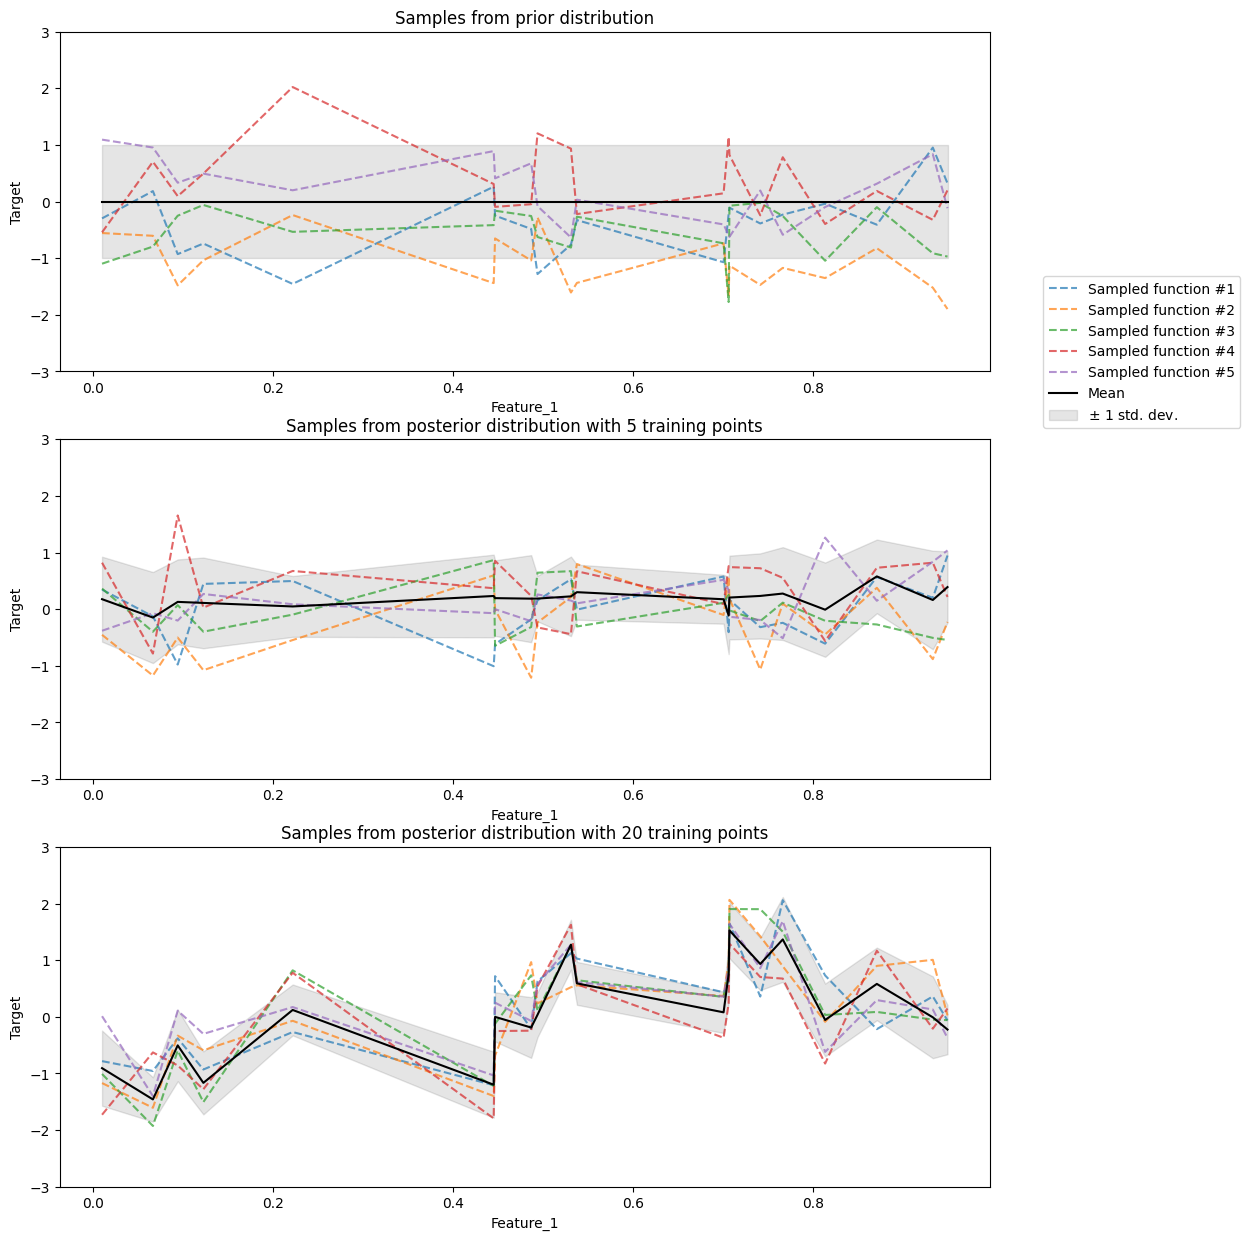

In [11]:
gp_model = gp_model_factory.create()
X_plot = test_data[model_features]
n_samples = 5
fig, axs = plt.subplots(nrows=3, figsize=(12, 15))

# plot prior
plot_gpr_samples(
    gp_model, n_samples = n_samples, x_plot = X_plot, 
    x_feature = 'Feature_1', ax = axs[0], 
    data_train = None, random_state = 42,
)
axs[0].set_title("Samples from prior distribution")

# plot posterior with 5 training samples
plot_gpr_samples(
    gp_model, n_samples = n_samples, x_plot = X_plot, 
    x_feature = 'Feature_1', ax = axs[1], 
    data_train = train_data[:5], random_state = 42,
)
axs[1].set_title("Samples from posterior distribution with 5 training points")

# plot posterior with 20 training samples
plot_gpr_samples(
    gp_model, n_samples = n_samples, x_plot = X_plot, 
    x_feature = 'Feature_1', ax = axs[2], 
    data_train = train_data[:20], random_state = 42,
)
axs[2].set_title("Samples from posterior distribution with 20 training points")

axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")